In [504]:
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram

import numpy as np
from scipy.optimize import minimize

In [505]:
# dij需求i到设施j的成本
d = [[1, 2], [1, 2]]
n = 2   # 两个设施点
m = 2   # 两个需求点
# d = [[1, 2], [3, 4], [5, 6]]
# n = 2   # 两个设施点
# m = 3   # 三个需求点
num_qubits = n * m + n

# gi设施i的建设成本
g = [1, 2]


In [506]:
penalty = 10
depth = 10
params = np.random.rand(depth * 2 + 1)

In [507]:
# dtype=np.complex128
def add_in_target(num_qubits, target_qubit, gate=np.array([[1, 0],[0, -1]])):
    H = np.eye(2 ** (target_qubit))
    H = np.kron(H, gate)
    H = np.kron(H, np.eye(2 ** (num_qubits - 1 - target_qubit)))
    return H


def generate_Hp(n, m, d, g):
    # 初始化 Hp 矩阵为零矩阵
    # print(num_qubits)
    Hp = np.zeros((2**num_qubits, 2**num_qubits))
    # for i in range(1, m + 1):
    #     for j in range(1, n + 1):
    #         # print(d[i - 1][j - 1])
    #         Hp += d[i - 1][j - 1] * (add_in_target(num_qubits, n * (i - 1) + j - 1) - np.eye(2**num_qubits)) / 2
    
    # for j in range(1, n + 1):
    #     Hp +=  g[j - 1] * (add_in_target(num_qubits, m * n + j - 1)- np.eye(2**num_qubits)) / 2

    for i in range(1, m + 1):
        Ht = np.zeros((2**num_qubits, 2**num_qubits))
        for j in range(1, n + 1):
            Ht += (np.eye(2**num_qubits) - add_in_target(num_qubits, n * (i - 1) + j - 1)) / 2
        Ht -= np.eye(2**num_qubits)
        Hp += -penalty * Ht @ Ht
    
    # for i in range(1, m + 1):
    #     for j in range(1, n + 1):
    #         Ht = (np.eye(2**num_qubits) - add_in_target(num_qubits, n * (i - 1) + j - 1)) / 2 + (np.eye(2**num_qubits) - add_in_target(num_qubits, n * (m + i) + j - 1)) / 2 + (np.eye(2**num_qubits) - add_in_target(num_qubits, m * n + j - 1)) / 2
    #         Hp += -penalty * Ht @ Ht

    return Hp

In [508]:
from scipy.linalg import expm
def build_circ(n, m, d, g, params):
  qc = QuantumCircuit(num_qubits)
  beta = params[:depth + 1]
  gamma = params[depth + 1:]
  for i in range(num_qubits):
    qc.h(i)
  for dp in range(depth):
    qc.unitary(expm(-1j * gamma[dp] * generate_Hp(n, m, d, g)), range(num_qubits))
    for i in range(num_qubits):
      qc.rx(beta[dp], i)
  qc.measure_all()
  return qc

In [509]:
def cost_function(x):
  num = [int(char) for char in x]
  C = 0
  # for i in range(1, m + 1):
  #   for j in range(1, n + 1):
  #     C += d[i - 1][j - 1] * num[n * (i - 1) + j - 1]
  # for j in range(1, 1 + n):
  #   C += g[j - 1] * num[m * n + j - 1]

  for i in range(1, m + 1):
    t = 0
    for j in range(1, n + 1):
      t += num[n * (i - 1) + j -1]
    C += penalty * (t - 1)**2

  # for i in range(1, m + 1):
  #   for j in range(1, n + 1):
  #     C += penalty * (num[n * (i - 1) + j - 1] + num[n * (m + i) + j - 1] - num[m * n + j - 1]) ** 2
  return C

def compute_expectation(counts):
  EV = 0
  total_count = 0
  for x, count in counts.items():
    C = cost_function(x)
    EV += C*count
    total_count += count

  return EV/total_count


def expectation_from_sample(shots = 2000):
  backend = Aer.get_backend('qasm_simulator')
  backend.shots = shots

  def execute_circ(theta):
    qc = build_circ(n, m, d, g, theta)
    counts = backend.run(qc, seed_simulator=10, shots=shots).result().get_counts()
    return compute_expectation(counts)
  
  return execute_circ

In [510]:
from scipy.optimize import minimize
import numpy as np

expectation = expectation_from_sample()

def callback(x):
    global iteration_count
    iteration_count += 1
    if iteration_count % 10 == 0:
        print(f"Iteration {iteration_count}, Result: {expectation(x)}")

# 设定最大迭代次数
max_iterations = 1000

# 初始化迭代计数器
iteration_count = 0

# 使用 COBYLA 方法进行最小化，并设置 callback 函数
res = minimize(expectation, params, method='COBYLA', options={'maxiter': max_iterations}, callback=callback)

# 输出最终结果
print("Final Result:", res)

Iteration 10, Result: 16.91
Iteration 20, Result: 13.295
Iteration 30, Result: 9.155
Iteration 40, Result: 17.31
Iteration 50, Result: 1.815
Iteration 60, Result: 0.265
Iteration 70, Result: 2.815
Iteration 80, Result: 0.06
Iteration 90, Result: 0.02
Iteration 100, Result: 0.15
Iteration 110, Result: 0.005
Iteration 120, Result: 0.005
Iteration 130, Result: 0.005
Iteration 140, Result: 0.005
Iteration 150, Result: 0.0
Iteration 160, Result: 0.0
Iteration 170, Result: 0.0
Iteration 180, Result: 0.0
Final Result:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.0
       x: [ 1.436e+00  6.312e-01 ...  9.553e-01  1.025e+00]
    nfev: 182
   maxcv: 0.0


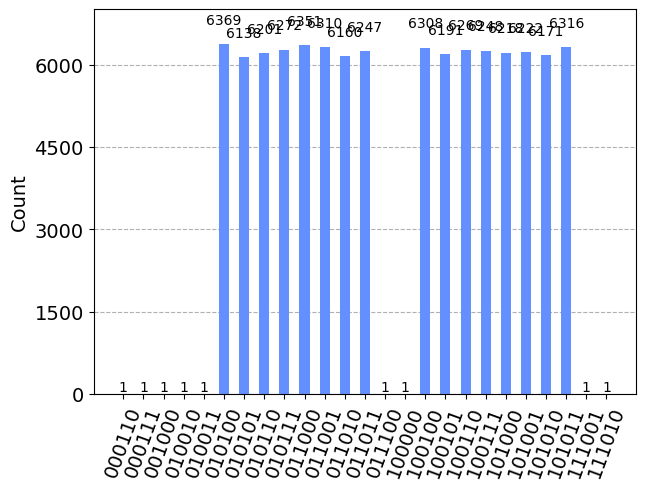

In [511]:
from numpy.lib.utils import source
backend = Aer.get_backend('aer_simulator')
backend.shots = 100000

shots=100000
qc_res = build_circ(n, m, d, g, params=res.x)

counts = backend.run(qc_res, seed_simulator=10, shots = shots).result().get_counts()
plot_histogram(counts)

In [512]:
sorted_counts = sorted(counts, key=counts.get, reverse=True)
for x in sorted_counts[:20]:
  print(x, "{:.3f}".format(counts[x] / shots), cost_function(x))

010100 0.064 0
011000 0.064 0
101011 0.063 0
011001 0.063 0
100100 0.063 0
010111 0.063 0
100110 0.063 0
100111 0.062 0
011011 0.062 0
101001 0.062 0
101000 0.062 0
010110 0.062 0
100101 0.062 0
101010 0.062 0
011010 0.062 0
010101 0.061 0
111010 0.000 10
100000 0.000 10
001000 0.000 10
000110 0.000 10
